<a href="https://colab.research.google.com/github/hanypoh/GAN-Picture/blob/main/Project_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision matplotlib


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os


In [ ]:
# Hyperparameters
latent_dim = 100
batch_size = 256
epochs = 5  # untuk waktu ~1 menit
lr = 0.0002

In [ ]:
# Dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])
dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Buat folder untuk menyimpan gambar
os.makedirs("gan_quick_images", exist_ok=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Inisialisasi model
G = Generator().to(device)
D = Discriminator().to(device)

# Loss dan Optimizer
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr)


In [ ]:
from time import time
start_time = time()

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(loader):
        real_imgs = real_imgs.to(device)
        b = real_imgs.size(0)

        # Label
        valid = torch.ones(b, 1, device=device)
        fake = torch.zeros(b, 1, device=device)

        # Train Discriminator
        z = torch.randn(b, latent_dim, device=device)
        fake_imgs = G(z).detach()

        loss_D = (criterion(D(real_imgs), valid) + criterion(D(fake_imgs), fake)) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(b, latent_dim, device=device)
        gen_imgs = G(z)
        loss_G = criterion(D(gen_imgs), valid)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

    # Simpan hasil di setiap epoch
    save_image(gen_imgs[:25], f"gan_quick_images/epoch_{epoch+1}.png", nrow=5, normalize=True)

print(f"Training selesai dalam {time() - start_time:.2f} detik")


Epoch [1/5] | Loss_D: 0.7877 | Loss_G: 0.6536
Epoch [2/5] | Loss_D: 0.4123 | Loss_G: 2.3767
Epoch [3/5] | Loss_D: 1.4976 | Loss_G: 1.5140
Epoch [4/5] | Loss_D: 0.7739 | Loss_G: 1.5224
Epoch [5/5] | Loss_D: 0.5440 | Loss_G: 1.6704
Training selesai dalam 198.54 detik


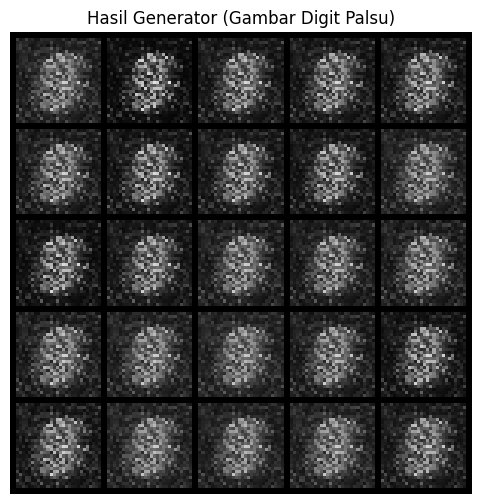

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Ukuran noise input
latent_dim = 100
G.eval()  # Set model ke mode evaluasi

# Buat noise acak (batch 25)
z = torch.randn(25, latent_dim).to(device)

# Hasilkan gambar dari noise
with torch.no_grad():
    fake_imgs = G(z)

# Normalize gambar: dari -1..1 → 0..1
fake_imgs = (fake_imgs + 1) / 2

# Buat grid gambar
grid = make_grid(fake_imgs.cpu(), nrow=5)

# Tampilkan dengan matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Hasil Generator (Gambar Digit Palsu)")
plt.axis("off")
plt.show()
